In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import re
import numpy as np

In [145]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [146]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

### Deviding training into labeled and unlabeld

In [147]:
train_labeled = train_data.sample(100)
train_unlabeled = train_data.drop(train_labeled.index)
train_labeled.shape, train_unlabeled.shape

((100, 17), (6614, 17))

### Removing all the labels from train_unlabeled

In [148]:
train_unlabeled["Y"] = np.nan

### Some info of the labeled data

In [149]:
train_labeled.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA50,X14_ CA59,Y
4851,0.320238,-0.238756,0.107831,-0.439547,-0.243736,1.774900,0.788269,0.280781,-0.496089,1.380106,1.0,0.0,0.0,0.0,0.0,0.0,Ford
2561,0.024726,0.020937,0.345005,0.910719,1.514350,-0.251152,0.823478,0.757002,-0.332523,-0.693151,1.0,0.0,0.0,0.0,1.0,0.0,BMW
5262,0.505558,-1.134321,-0.485105,0.697519,-0.500535,2.118981,0.189712,-0.433549,-0.262423,1.080305,1.0,0.0,0.0,0.0,0.0,0.0,Ford
3966,-1.375198,0.260707,0.819354,0.271119,0.901983,-0.553798,0.400968,1.090356,0.088075,-0.934845,0.0,0.0,1.0,1.0,0.0,0.0,Mercedes
3368,0.129908,0.151721,-1.078041,-1.162058,-0.836349,-0.090220,0.330549,0.995112,0.391841,0.211194,0.0,1.0,0.0,0.0,0.0,0.0,BMW


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,100,object,6
X1,X1,100,float64,96
X2,X2,100,float64,94
X3,X3,100,float64,33
X4,X4,100,float64,71
X5,X5,100,float64,63
X6,X6,100,float64,96
X7,X7,100,float64,55
X8,X8,100,float64,53
X9,X9,100,float64,73


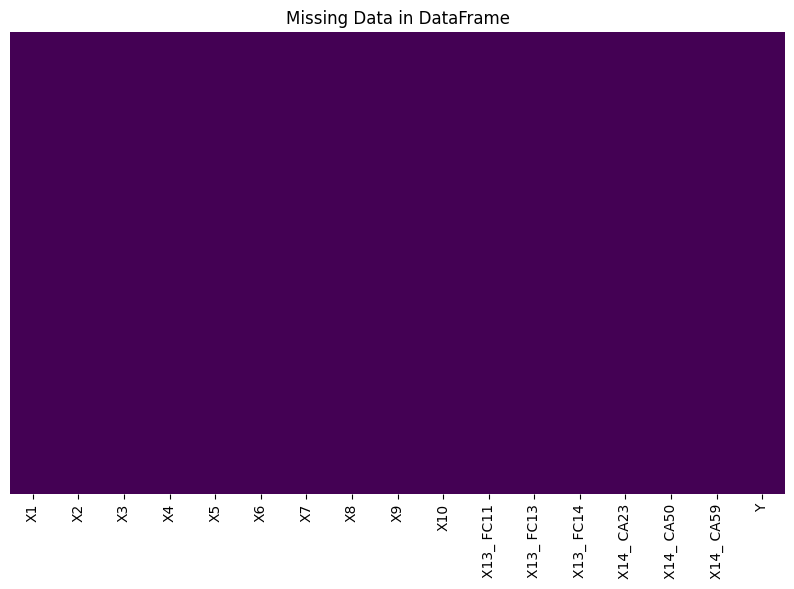

In [150]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_labeled, sort_by='Column')


In [151]:
X_train_labeled = train_labeled.drop('Y', axis=1)
y_train_labeled = pd.get_dummies(train_labeled['Y'])

X_train_unlabeled = train_unlabeled.drop('Y', axis=1)
y_train_unlabeled = pd.get_dummies(train_unlabeled['Y'])


X_val = val_data.drop('Y', axis=1)
y_val = pd.get_dummies(val_data['Y'])

X_test = test_data.drop('Y', axis=1)
y_test = pd.get_dummies(test_data['Y'])


In [152]:
classes = train_labeled["Y"].unique()
num_classes = y_train_labeled.shape[1]
input_features = X_train_labeled.shape[1]
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {num_classes}")
print(f"Number of features: {input_features}")
print(f"X_train shape: {X_train_labeled.shape}, y_train shape: {y_train_labeled.shape}" )

print(categorical_cols)

The classes is: ['Ford' 'BMW' 'Mercedes' 'GMC' 'Honda' 'Toyota']
Number of classes: 6
Number of features: 16
X_train shape: (100, 16), y_train shape: (100, 6)
Index(['Y'], dtype='object')


# Building Model

In [153]:
import xgboost as xgb
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Initialize model parameters
n_estimators = 100
max_depth = 7
learning_rate = 0.1
iteration = 1

# Set the number of iterations and number of samples to move from unlabeled to labeled
num_samples_to_move = 20

while len(X_train_unlabeled) > 0:
    # Train the model
    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=777)
    model.fit(X_train_labeled, y_train_labeled)

    # Evaluate the model
    ta = f1_score(y_train_labeled, model.predict(X_train_labeled), average='weighted')
    va = f1_score(y_val, model.predict(X_val), average='weighted')
    print(f"Iteration {iteration}:")
    print(f"  Train F1 score: {ta:.2f}")
    print(f"  Validation F1 score: {va:.2f}")

    # Predict probabilities on the unlabeled dataset
    proba = model.predict_proba(X_train_unlabeled)

    # Select the samples with least confidence
    # Here we consider the max probability across all classes and select the ones with least of these values
    confidence = np.max(proba, axis=1)
    least_confidence_indices = np.argsort(confidence)[:num_samples_to_move]

    # Move these samples from unlabeled to labeled dataset
    X_train_labeled = pd.concat([X_train_labeled, X_train_unlabeled.iloc[least_confidence_indices]])
    y_train_labeled = pd.concat([y_train_labeled, y_new_labels.iloc[least_confidence_indices]]) # Assuming y_new_labels are the labels for unlabeled data

    # Remove these samples from the unlabeled dataset
    X_train_unlabeled = X_train_unlabeled.drop(X_train_unlabeled.index[least_confidence_indices])
    y_new_labels = y_new_labels.drop(y_new_labels.index[least_confidence_indices]) # Assuming y_new_labels are the labels for unlabeled data

    # Increment the iteration counter
    iteration += 1

    

    


Iteration 1:
  Train F1 score: 1.00
  Validation F1 score: 0.68


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126], got [False nan False nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan False nan nan
 False nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan False nan nan nan nan nan nan nan nan nan nan nan nan nan
 False True nan]

In [ ]:
y_train_labeled

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# Initial model parameters
n_estimator = 1000
max_depth = 7
learning_rate = 0.1
num_iterations = 150  # Set the number of iterations for active learning
num_samples_to_move = 50  # Number of samples to move in each iteration

for iteration in range(num_iterations):
    # Train the model
    model = xgb.XGBClassifier(n_estimators=n_estimator, max_depth=max_depth, learning_rate=learning_rate, random_state=777)
    model.fit(X_train_labeled, y_train_labeled)

    # Evaluate the model
    ta = f1_score(y_train_labeled, model.predict(X_train_labeled), average='weighted')
    va = f1_score(y_val, model.predict(X_val), average='weighted')
    print(f"Iteration {iteration}:")
    print(f"  Train F1 score: {ta:.2f}")
    print(f"  Validation F1 score: {va:.2f}")

    # Predict on the unlabeled data
    unlabeled_probs = model.predict_proba(X_train_unlabeled)
    unlabeled_predictions = model.predict(X_train_unlabeled)

    # Select the most confident predictions
    most_confident_indices = np.argsort(-unlabeled_probs.max(axis=1))[:num_samples_to_move]
    selected_samples = X_train_unlabeled.iloc[most_confident_indices]
    selected_labels = unlabeled_predictions[most_confident_indices]

    # Ensure that the selected_labels are in the correct format
    # Convert to a numpy array if it's not already
    selected_labels = np.array(selected_labels)

    # Check for NaN or invalid values in selected_labels and handle them if necessary
    # For example, you can replace NaN with a default class or remove such samples

    # Update the labeled dataset
    X_train_labeled = pd.concat([X_train_labeled, selected_samples])
    y_train_labeled = np.concatenate([y_train_labeled, selected_labels])

    # Update the unlabeled dataset by dropping the selected indices
    X_train_unlabeled.drop(selected_samples.index, inplace=True)

    print(f"  Number of samples in labeled dataset: {len(X_train_labeled)}")
    print(f"  Number of samples in unlabeled dataset: {len(X_train_unlabeled)}")
    print("-" * 100)



